# TME 9 FDMS, problèmes de bandits

In [72]:
#import
%matplotlib inline
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Lecture du fichier
Chaque ligne contient:

__ numéro article -- représentation de l'article 5 dimensions -- taux de clics sur les publicité de 10 annonceurs __

In [73]:
f = open("./CTR.txt")
ctr=[]
for i in f.readlines():
    line = i.split(':')
    ctr.append([int(line[0]),[float(i) for i in line[1].split(';')],[float(i) for i in line[2][:-2].split(';')]]) 

In [74]:
#Affichage des données pour l'article 0
ctr[0]

[0,
 [0.74837091377052,
  0.8352077827766918,
  0.07669895743095312,
  0.17243898920810596,
  0.14344585283799294],
 [0.10341905704918021,
  0.19069778281037159,
  0.0,
  0.10240139196802925,
  0.0363124254124334,
  0.07456195450906297,
  0.2347024151796051,
  0.0,
  0.0,
  0.07857372422425657]]

---
** Le but est de prédire la publicité d'un des 10 annonceurs permettant d'engranger le plus fort taux de clics **

Pour cela nous avons écrit différents algorithmes nous permettant d'évaluer :

**baseRandom** : le choix parmi les 10 annonceurs est fait de manière aléatoire

**baseStaticBest** : on choisit l'annonceur qui à le plus fort taux en moyenne

**baseStaticBestCum** : pareil que StaticBest mais ce choix est fait de manière cumulée (ligne après ligne)

**baseOptimal** : Il s'agit du choix optimal, c'est ce que nous voudrions atteindre avec nos algorithmes

In [75]:
def baseRandom(ctr):
    trace=[]
    score=[]
    annonceur=[]
    nb_annonceurs=len(ctr[0][2])
    for a in ctr:
        id=random.randint(0,nb_annonceurs-1)
        score.append(a[2][id])
        annonceur.append(id)
        trace.append(np.array(score).sum())
    return np.array(score),np.array(annonceur),trace

def baseStaticBest(ctr):
    sum=np.zeros(len(ctr[0][2]))
    for a in ctr:
        sum+=np.array(a[2])
    argmax=np.array(sum).argmax()
    annonceur = np.ones(len(ctr))*argmax
    score = np.array([i[2][argmax] for i in ctr])
    trace= np.array([score[0:idx].sum() for idx,i in enumerate(score)])
    return score,annonceur,trace

def baseStaticBestCum(ctr):
    sum=np.zeros(len(ctr[0][2]))
    annonceur = []
    score = []
    trace=[]
    for a in ctr:
        sum+=np.array(a[2])
        idmax = np.array(sum).argmax()
        annonceur.append(idmax)
        score.append(a[2][idmax])
        trace.append(np.array(score).sum())
    return np.array(score),np.array(annonceur),trace

def baseOptimal(ctr):
    score=[]
    annonceur=[]
    trace=[]
    for a in ctr:
        id=np.array(a[2]).argmax()
        score.append(a[2][id])
        annonceur.append(id)
        trace.append(np.array(score).sum())
    return np.array(score),np.array(annonceur),trace

### Analyse des scores cumulés

In [76]:
#Score optimal
score,annonceur,traceOptimal = baseOptimal(ctr)
score.sum()

1532.0032357358157

Nous obtenons un score cumulé optimal de 1532.00 il correspond au fait qu'a chaque visite nous ayons choisit la publicité avec le plus fort taux de clic.

Les scores des autres baseline seront bien entendu en dessous, le but est de se rapprocher de ce score.

In [77]:
#Score random
score,annonceur,traceRandom = baseRandom(ctr)
score.sum()

395.22910907511209

Le score random est faible et éloigné de l'optimal

In [78]:
#Score Static Best
score,annonceur,traceStaticBest = baseStaticBest(ctr)
score.sum()

1339.6350310465791

In [79]:
#Score Static Best Cum
score,annonceur,traceStaticBestCum = baseStaticBestCum(ctr)
score.sum()

1339.8983608672656

Le score des algorithmes "Static" sont semblables et représentent une bonne solution étant donné que leurs scores est proche de l'optimal.

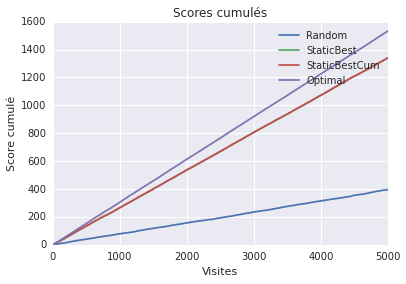

In [80]:
#Affichage des scores
plt.plot(traceRandom, label = "Random")
plt.plot(traceStaticBest, label = "StaticBest")
plt.plot(traceStaticBestCum, label = "StaticBestCum")
plt.plot(traceOptimal, label = "Optimal")
plt.xlabel("Visites")
plt.ylabel(u"Score cumulé")
plt.title(u"Scores cumulés")
plt.legend()
plt.show()

# UCB

Developpement de l'article UCB.
La stratégie centrale est la suivante:

$π_t = arg max_i B_{t,T_i (t−1)}(i)$ 

avec 

$ B_{t,s}(i) = \mu_{i,s} + \sqrt{\dfrac{2log t}{s}}$

Le principe est de choisir un annonceur ayant le plus de chance d'etre l'annonceur avec le plus fort taux de clics en fonction des annonces précédentes tout en prenant en compte le fait que l'on doive tester les autres annonceurs (d'où l'ajout du $+ \sqrt{\dfrac{2log t}{s}}$).

Avec cette méthode on évite de rester sur un bras sous-optimal.

In [81]:
def UCB(ctr):
    score=[]
    annonceur=[]
    trace=[]
    nbAds=len(ctr[0][2])
    
    #poids de chaque ads
    weights= np.zeros(nbAds)
    
    #tableau compte nombre de fois qu'une ads a été choisie
    arrayS=np.zeros(nbAds)
    
    #initialisation 10 première lignes 10 ads 
    t=0
    for it in np.arange(nbAds):
        t+=1
        arrayS[it]+=1
        weights[it]+=ctr[it][2][it]
    
    
    #algo UCB
    for a in ctr:
        #calcul du argmax de l'itération précédente
        mu=np.zeros(nbAds)
        for it in np.arange(nbAds):
            mu[it]+=weights[it]/arrayS[it]+np.square((2*np.log(t))/arrayS[it]) 
        argmax = np.argmax(np.array(mu))
        
        #maj des valeurs uniquement celle de l'argmax !! 
        t+=1
        arrayS[argmax]+=1
        weights[argmax]+=a[2][argmax]
        
        score.append(a[2][argmax])
        annonceur.append(argmax)
        trace.append(np.array(score).sum())
    return np.array(score),np.array(annonceur),trace
        
 
    

In [82]:
#calcul des scores pour UCB
score,annonceur,UCB = UCB(ctr)
score.sum()

1272.2319832867825

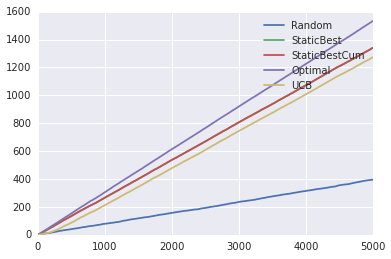

In [83]:
plt.plot(traceRandom, label = "Random")
plt.plot(traceStaticBest, label = "StaticBest")
plt.plot(traceStaticBestCum, label = "StaticBestCum")
plt.plot(traceOptimal, label = "Optimal")
plt.plot(UCB, label = "UCB")
plt.legend()
plt.show()

On remarque que l'algorithme UCB a un moins bon score que Static Best, cela est du au fait que l'agorithme aille tester les autres bras (autre annonceurs) ce qui peut lui faire faire des choix sous optimaux. 

# Lin UCB

Jusque là nous avons basé nos choix sur le résultat d'une action précédente et non pas grâce au contexte. Or ici le contexte peut être très utile pour déterminer le taux de clic pour un annonceur. En effet, avoir des informations sur un produit en question peut nous aider à déterminer quel annonceur choisir.

Nous allons donc implémenter le problème de **bandits contextuels**

In [203]:
def predict(theta,ctr):
    score=[]
    annonceur=[]
    trace=[]
    for a in ctr:
        arg = np.array([(arg.dot(a[1])) for arg in theta]).argmax()
        score.append(a[2][arg])
        annonceur.append(id)
        trace.append(np.array(score).sum())
    return score,annonceur,trace

In [234]:
def linUCB(ctr,alpha):
    
    #nb annonceurs 
    nb_a = len(ctr[0][2])
    #nb features par objet = d
    d = len(ctr[0][1])
    
    A = np.array([np.identity(d) for i in np.arange(nb_a)])
    b = np.zeros((nb_a,d)) 

    theta = np.zeros((nb_a,d))
    p=np.zeros(nb_a)
    
    argmax=np.zeros(len(ctr), int)
    for t,annonce in enumerate(ctr):        
        objet=np.array(annonce[1])
        for idx,c in enumerate(annonce[2]):
            inverse = np.linalg.inv(A[idx])
            theta[idx] = inverse.dot(b[idx])
            p[idx] = theta[idx].dot(objet) + alpha*np.sqrt(objet.dot(inverse.dot(objet)))
        argmax[t] = np.random.choice(np.where(p==p.max())[0])
        A[argmax[t]] += objet.dot(objet)
        b[argmax[t]] += annonce[2][argmax[t]]*objet
    return A,b,theta,argmax

In [237]:
x=np.arange(0,1,0.1)
tabTrace=[]
for i in x:
    A,b,theta,argmax = linUCB(ctr,i)
    score,annonceur,linUCBTrace = predict(theta,ctr)
    tabTrace.append(linUCBTrace)
    print(i)
    print(linUCBTrace[-1])

0.0
1045.7926412
0.1
1297.44675608
0.2
1305.23741888
0.3
1297.51841934
0.4
1291.08097916
0.5
1313.82155985
0.6
1288.48479701
0.7
1298.1303456
0.8
1287.08184319
0.9
1286.33077375


In [228]:
np.arange(0,1,0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

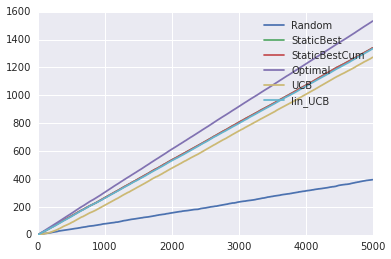

In [206]:
plt.plot(traceRandom, label = "Random")
plt.plot(traceStaticBest, label = "StaticBest")
plt.plot(traceStaticBestCum, label = "StaticBestCum")
plt.plot(traceOptimal, label = "Optimal")
plt.plot(UCB, label = "UCB")
plt.plot(linUCBTrace, label = "lin_UCB")
plt.legend()
plt.show()

#### premiere version de lin ucb ..

In [201]:
def linUCB_V1(ctr,sigma):
    #nb annonceurs 
    nb_a = len(ctr[0][2])
    
    #nb features par objet = d
    d = len(ctr[0][1])
    
    alpha = 1+np.sqrt(np.log(2/sigma)/2)
    A = np.array([np.identity(d) for i in np.arange(nb_a)])
    b = np.zeros((nb_a,d)) 
    
    Atmp = np.array([np.identity(d) for i in np.arange(nb_a)])
    btmp = np.zeros((nb_a,d)) 
    
    theta = np.zeros((nb_a,d))
    p=np.zeros((nb_a,d,d))

    for t,annonce in enumerate(ctr,1):

            
        objet=np.array(annonce[1])
        objetT=objet.T
        for idx,c in enumerate(annonce[2]):
            Atmp[idx] = objetT*objet+np.identity(d)
            btmp[idx] = objet*c
            theta[idx] = np.linalg.inv(Atmp[idx]).dot(btmp[idx])
            p[idx] = theta[idx].T*objet + alpha*np.sqrt(objetT*np.linalg.inv(Atmp[idx])*objet)
        argmax = np.argmax(p)
        A[argmax] = A[argmax] + objet * objetT
        b[argmax] = np.array(annonce[2][argmax])*objet
    return A,b,theta

1068.03754304


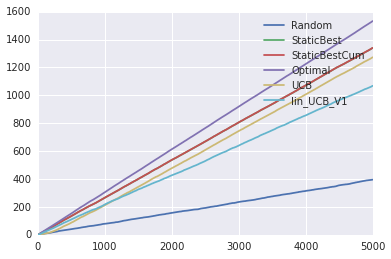

In [202]:
A,b,theta= linUCB_V1(ctr,0.5)

score,annonceur,testTrace = predict(theta,ctr)
print(testTrace[-1])

plt.plot(traceRandom, label = "Random")
plt.plot(traceStaticBest, label = "StaticBest")
plt.plot(traceStaticBestCum, label = "StaticBestCum")
plt.plot(traceOptimal, label = "Optimal")
plt.plot(UCB, label = "UCB")
plt.plot(testTrace, label = "lin_UCB_V1")
plt.legend()
plt.show()